In [3]:
import pickle
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from sklearn.datasets import make_regression
from numpy import asarray, mean, std
from xgboost import XGBRegressor
from matplotlib import pyplot
from hyperopt import fmin, tpe, hp, STATUS_OK

# XGBoost-specific data preparation

In [32]:
df_all_identified = pd.read_csv('data_RO2/df_ml_ready.csv')

## Combine SMILES into one string where there are multiple

In [33]:
etl_combined_SMILES = []
htl_combined_SMILES = []

df_all_identified['etl_SMILES'] = df_all_identified['etl_SMILES'].apply(ast.literal_eval)
df_all_identified['htl_SMILES'] = df_all_identified['htl_SMILES'].apply(ast.literal_eval)

for index, row in df_all_identified.iterrows():
    etl_combination = ".".join(row['etl_SMILES'])
    htl_combination = ".".join(row['htl_SMILES'])
    etl_combined_SMILES.append(etl_combination)
    htl_combined_SMILES.append(htl_combination)
df_all_identified['etl_combined_SMILES'] = etl_combined_SMILES
df_all_identified['htl_combined_SMILES'] = htl_combined_SMILES

df_all_identified['etl_combined_SMILES'] = df_all_identified['etl_combined_SMILES'].str.replace('no_ctl', '')
df_all_identified['htl_combined_SMILES'] = df_all_identified['htl_combined_SMILES'].str.replace('no_ctl', '')


In [34]:
# drop device_stack column which is unnecessary here
df_all_identified = df_all_identified.drop(columns=['device_stack'])

,reduced_formulas,etl,htl,bandgap,pce,etl_SMILES,htl_SMILES,etl_combined_SMILES,htl_combined_SMILES
0,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.86,3.530000,"[O=[Ti]=O, O=[Ti]=O]",[CCCCCCC1=C(SC(=C1)C)C],O=[Ti]=O.O=[Ti]=O,CCCCCCC1=C(SC(=C1)C)C
1,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['PTB7-th'],1.86,3.530000,"[O=[Ti]=O, O=[Ti]=O]",[CCC(=CF)COC1=CC=C(C=C1)C23CCC(CC2)(CC3)C(=O)N...,O=[Ti]=O.O=[Ti]=O,CCC(=CF)COC1=CC=C(C=C1)C23CCC(CC2)(CC3)C(=O)NC...
2,Ag2BiI5,"['TiO2-c', 'TiO2-mp']",['PTAA'],2.22,2.600000,"[O=[Ti]=O, O=[Ti]=O]",[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C],O=[Ti]=O.O=[Ti]=O,CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C
3,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.80,2.320000,"[O=[Ti]=O, O=[Ti]=O]",[CCCCCCC1=C(SC(=C1)C)C],O=[Ti]=O.O=[Ti]=O,CCCCCCC1=C(SC(=C1)C)C
4,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['PTAA'],0.00,4.300000,"[O=[Ti]=O, O=[Ti]=O]",[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C],O=[Ti]=O.O=[Ti]=O,CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C
...,...,...,...,...,...,...,...,...,...
5444,CsI3Sn,['TiO2-c'],['PTAA'],0.00,3.866667,[O=[Ti]=O],[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C],O=[Ti]=O,CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C
5445,CsI3Sn,"['TiO2-c', 'TiO2-mp']",['PTAA'],0.00,3.790000,"[O=[Ti]=O, O=[Ti]=O]",[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C],O=[Ti]=O.O=[Ti]=O,CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C
5446,CsI3Sn,"['TiO2-c', 'TiO2-mp']",['PTAA'],1.30,3.655000,"[O=[Ti]=O, O=[Ti]=O]",[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C],O=[Ti]=O.O=[Ti]=O,CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C
5447,CsI3Sn,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],0.00,2.230000,"[O=[Ti]=O, O=[Ti]=O]",[COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=C...,O=[Ti]=O.O=[Ti]=O,COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=C3...


In [35]:
def parse_formula(formula):
    matches = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    element_counts = {}
    for (element, count) in matches:
        if element in element_counts:
            element_counts[element] += int(count) if count else 1
        else:
            element_counts[element] = int(count) if count else 1
    return element_counts

# Unique elements across all formulas
ELEMENTS = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'B', 'Li', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ti', 'V', 
            'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
            'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

# Create columns for each element count
for element in ELEMENTS:
    df_all_identified[element] = df_all_identified['reduced_formulas'].apply(lambda x: parse_formula(x).get(element, 0))

    
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)    
    
def smiles_to_fingerprint(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.zeros(fpgen.GetNumBits(),)
    fp = fpgen.GetFingerprint(molecule)
    # Convert to a bit vector
    bit_vector = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, bit_vector)
    return bit_vector


# Create columns for Morgan Fingerprints
etl_fingerprints = df_all_identified['etl_combined_SMILES'].apply(smiles_to_fingerprint)
htl_fingerprints = df_all_identified['htl_combined_SMILES'].apply(smiles_to_fingerprint)

# Convert fingerprints to DataFrame
etl_fingerprint_df = pd.DataFrame(etl_fingerprints.tolist(), columns=[f'ETL_FP_{i}' for i in range(1024)])
htl_fingerprint_df = pd.DataFrame(htl_fingerprints.tolist(), columns=[f'HTL_FP_{i}' for i in range(1024)])

# Combine all features into a single DataFrame
features_df = pd.DataFrame
features_df = pd.concat([df_all_identified.drop(columns=['reduced_formulas',
                                                         'etl', 
                                                         'htl', 
                                                         'etl_SMILES',
                                                         'htl_SMILES',
                                                         'etl_combined_SMILES',
                                                         'htl_combined_SMILES']), etl_fingerprint_df, htl_fingerprint_df], axis=1)

print(len(features_df))
features_df = features_df.dropna()
print(len(features_df))

[16:24:50] WARNING: not removing hydrogen atom without neighbors
[16:25:07] WARNING: not removing hydrogen atom without neighbors
[16:25:07] WARNING: not removing hydrogen atom without neighbors


5449
5449


# XGBoost Predictions
## Absorber only
### Train Test Split

In [48]:
X = features_df.iloc[:, :78].drop(columns='pce')
y = features_df['pce']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X.shape, y.shape)

(5449, 77) (5449,)


In [49]:
model_abs_only = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_abs_only, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# training
model_abs_only = XGBRegressor(objective='reg:squarederror')
model_abs_only.fit(X_train, y_train)

MAE: -2.911 (0.132)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
# Make predictions on the test set
y_pred = model_abs_only.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 2.829
Mean Squared Error (MSE): 13.167
R^2 Score: 0.408


## Absorber and Label Encoding

In [58]:
X = features_df.iloc[:, :78].drop(columns='pce')
y = features_df['pce']

# Get the unique values
etl_values = df_all_identified['etl'].unique()
htl_values = df_all_identified['htl'].unique()

# Create a dictionary mapping each value to an integer
etl_dict = {value: index for index, value in enumerate(etl_values)}
htl_dict = {value: index for index, value in enumerate(htl_values)}

# Replace each value with its corresponding integer
X['etl_encoded'] = df_all_identified['etl'].map(etl_dict)
X['htl_encoded'] = df_all_identified['htl'].map(htl_dict)

### Train Test Split

In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X.shape, y.shape)

(5449, 79) (5449,)


### Training

In [56]:
model_label_encoding = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_label_encoding, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# training
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

MAE: -2.636 (0.106)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 2.416
Mean Squared Error (MSE): 10.318
R^2 Score: 0.536


## Absorber and Fingerprints
### Train Test Split

In [36]:
X = features_df.drop(columns=['pce'])
y = features_df['pce']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X.shape, y.shape)

(5449, 2125) (5449,)


### Training

In [37]:
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# training
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

MAE: -2.586 (0.084)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 2.510
Mean Squared Error (MSE): 10.649
R^2 Score: 0.539


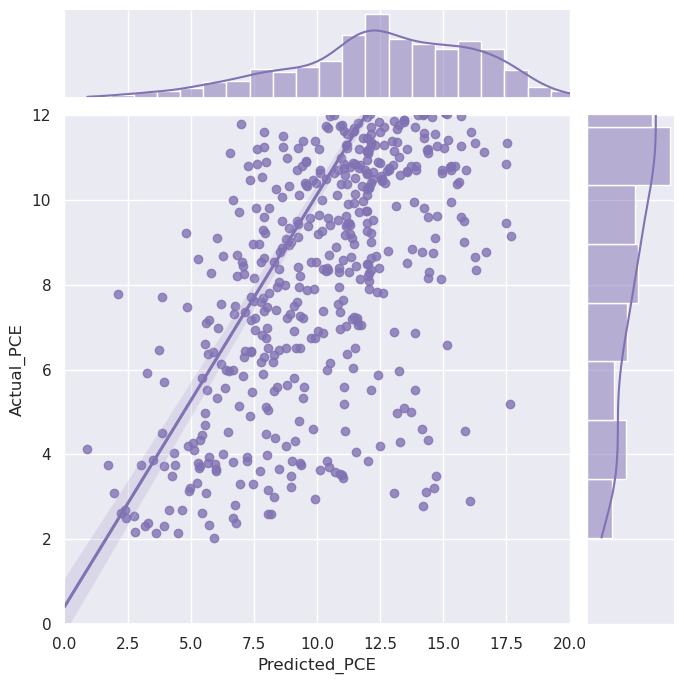

In [39]:
sns.set_theme(style="darkgrid")

eval_data = pd.DataFrame({
    'Predicted_PCE': y_pred,
    'Actual_PCE': y_test
})

g = sns.jointplot(x="Predicted_PCE", y="Actual_PCE", data=eval_data,
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 12),
                  color="m", height=7)

# Bayesian Optimization for Hyperparameters in XGBoost

In [195]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 32, 1),
    'learning_rate': hp.loguniform('learning_rate', -6, -1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'gamma': hp.uniform('gamma', 0, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

def objective(params):
    xgb_model = XGBRegressor(
        max_depth=int(params['max_depth']),  # Ensure max_depth is an integer
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        n_estimators=int(params['n_estimators']),  # Ensure n_estimators is an integer
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree']
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK}

best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [21:04:55<00:00, 758.96s/trial, best loss: 2.818788301165285]   
Best set of hyperparameters:  {'colsample_bytree': 0.5682614956521421, 'gamma': 3.1898711558058657, 'learning_rate': 0.009785766924919498, 'max_depth': 20.0, 'n_estimators': 600.0, 'subsample': 0.669097735381701}


# Training with optimal values
best_params = {
    'learning_rate': 0.037580732411128234,
    'max_depth': 16,
    'subsample': 0.7092227823999635
}

Mean Absolute Error (MAE): 2.873
Mean Squared Error (MSE): 15.159
R^2 Score: 0.541

{'colsample_bytree': 0.5682614956521421,
               'gamma': 3.1898711558058657,
               'learning_rate': 0.009785766924919498,
               'max_depth': 20,
               'n_estimators': 600,
               'subsample': 0.669097735381701}
               


In [198]:
best_params = {'colsample_bytree': 0.5682614956521421,
               'gamma': 3.1898711558058657,
               'learning_rate': 0.009785766924919498,
               'max_depth': 20,
               'n_estimators': 600,
               'subsample': 0.669097735381701}

optim_model = XGBRegressor(**best_params)

# Train the model
optim_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = optim_model.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 2.819
Mean Squared Error (MSE): 14.354
R^2 Score: 0.565


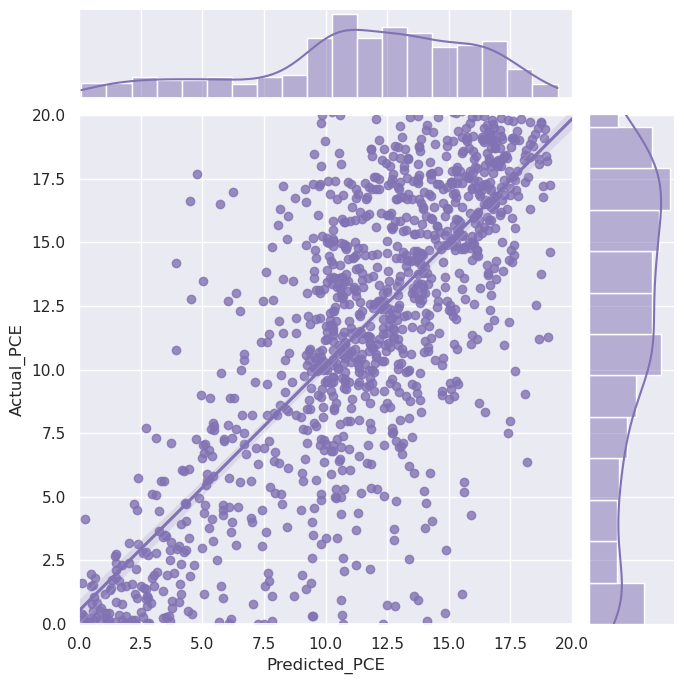

In [200]:
sns.set_theme(style="darkgrid")

eval_data = pd.DataFrame({
    'Predicted_PCE': y_pred,
    'Actual_PCE': y_test
})

g = sns.jointplot(x="Predicted_PCE", y="Actual_PCE", data=eval_data,
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 20),
                  color="m", height=7)